# Kaggle Titanic Competition
Using dataquest tutorial from [here](https://www.dataquest.io/mission/74/getting-started-with-kaggle)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import regular expression
import re

#import operator
import operator as op 

In [2]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold
from sklearn import cross_validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# Visualise in notebook
%matplotlib inline

## Dataset
Read and display dataset.

Use the pandas library in python to read in the csv file. It creates a DataFrame.

In [4]:
titanic = pd.read_csv("./data/train.csv")

In [7]:
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
titanic.describe()

C:\Users\Didier\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data "wrangling"
We want to replace missing values and transform non numeric values to numeric.
- **Age** column: replace missing values by the median.
- **Sex** column: Replace **male** by **0** and **female** by **1**.
- **Embarkment** column: replace missing values by "S" (the most common embarkment port) and then "S" = 0, "C = 1 and "Q" = 2.

In [9]:
# Age column

titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

In [10]:
# Sex column

titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
titanic["Sex"]= titanic["Sex"].astype(int)

In [11]:
# Embarkment column

titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2
titanic["Embarked"]= titanic["Embarked"].astype(int)

# An alternative to the above:
# titanic['Embarked'] = titanic['Embarked'].apply(lambda s: dict(S=0, C=1, Q=2)[s])

## Linear regression
We first use an ordinary least squares Linear Regression algorithm with the following features:

```["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]```

In [12]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class with default values, i.e.:
# (fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

algo_lr = LinearRegression()

Generate cross validation folds: Split the dataset in 3 folds, each fold having a training set and a test set.

So here, with a dataset of 891 rows:
- First fold: training index 297->890, test index 0->296
- Second fold: training index 0->296;594->890, test index 297->593
- Third fold: training index 0->593, test index 594->890

In [13]:
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

For each fold:
- Train the algorithm on the **training** data set (**algo_lr.fit()**)
- Use the trained algorithm to make predictions on the **test** data set (**algo_lr.predict()**)

In [14]:
predictions = None
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    
    # Training the algorithm using the predictors and target.
    algo_lr.fit(train_predictors, train_target)
    
    # We can now make predictions on the test fold
    test_predictions = algo_lr.predict(titanic[predictors].iloc[test,:])
    if predictions is None:
        predictions = test_predictions
    else:
        predictions = np.concatenate((predictions, test_predictions),axis=0)

This is linear regression. We need to map predictions to the outcome of a logistic regression, i.e. **0** or **1**. Anything > 0.5 is set to 1, anything <= 0.5 is set to 0.

In [15]:
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

Calculate our error metric, which is here Accuracy, i.e. percentage of correct predictions (number of correct predictions divided by the number of row in dataset (=number of passengers))

In [16]:
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.783389450056


C:\Users\Didier\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


## Logistic Regresion
Using a proper Logistic Regression algorithm now. On same dataset than the Linear Regression.

Initialise the algorithm with all default parameters.

In [17]:
alg = LogisticRegression()

Calculate the error metric. Here we can evaluate the score directly by using the cross_validation class, cross_val_score method. Parameter to be provided:
- the estimator (implementing the **fit** method), here our Logistic Regression **alg**
- the features
- the target vector
- **cv** parameter that determines the cross validation strategy. An integer will use Kfold iterator. One can provide another Cross Validation operator instead of integer.

In [18]:
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Show scores for each cv fold

scores

array([ 0.78451178,  0.78787879,  0.79124579])

In [19]:
#compute scores mean
print("Scores mean:",scores.mean())

Scores mean: 0.787878787879


## Random Tree Forest
Using ensembling method now. Here, Random Tree Forest (RandomForestClassifier class). Initialisation of the algorithm with:
- n_estimators, is the number of decision tree
- min_samples_split is the minimum number of rows we need to make a split
- min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)

In [20]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

Calculate the score.

In [21]:
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print("scores:",scores,"Mean:",scores.mean())

scores: [ 0.8013468   0.82828283  0.83164983] Mean: 0.820426487093


By modifying some of the parameters of the Random Tree Forest, we can (try to!) improve the score.

In [22]:
alg = RandomForestClassifier(random_state=1, n_estimators=20, min_samples_split=2, min_samples_leaf=2)

In [23]:
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print("scores:",scores,"Mean:",scores.mean())

scores: [ 0.81144781  0.81144781  0.83164983] Mean: 0.818181818182


Let's us brute force to find the best parameters!

In [36]:
best_scores = best_ne = best_mss = best_msl = 0
for ne in range(10,200,10):
    for mss in range(1,15):
        for msl in range(1,15):
            alg = RandomForestClassifier(random_state=1, n_estimators=ne, min_samples_split=mss, min_samples_leaf=msl)
            scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
            if best_scores < scores.mean():
                best_scores = scores.mean()
                best_ne = ne
                best_mss = mss
                best_msl = msl
                print("New best score: ",best_scores)
                print("with n_estimators:",best_ne,"min_samples_split:",best_mss,"min_samples_leaf:",best_msl)

New best score:  0.801346801347
with n_estimators: 10 min_samples_split: 1 min_samples_leaf: 1
New best score:  0.819304152637
with n_estimators: 10 min_samples_split: 1 min_samples_leaf: 2
New best score:  0.822671156004
with n_estimators: 10 min_samples_split: 5 min_samples_leaf: 2
New best score:  0.82379349046
with n_estimators: 10 min_samples_split: 6 min_samples_leaf: 1
New best score:  0.826038159371
with n_estimators: 10 min_samples_split: 11 min_samples_leaf: 4
New best score:  0.830527497194
with n_estimators: 10 min_samples_split: 12 min_samples_leaf: 4
New best score:  0.832772166105
with n_estimators: 20 min_samples_split: 10 min_samples_leaf: 2
New best score:  0.833894500561
with n_estimators: 30 min_samples_split: 10 min_samples_leaf: 3
New best score:  0.836139169473
with n_estimators: 40 min_samples_split: 10 min_samples_leaf: 2
New best score:  0.837261503928
with n_estimators: 160 min_samples_split: 11 min_samples_leaf: 1


## Adding new features
Create additional features:
- **FamilySize**: Siblings + Parents (SibSp + Parch)
- **Title** (e.g. Mr, Miss, Dr, etc.)
- **Being member**: Being member of a family

### Family Size

In [146]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [147]:
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,51
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,44
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,24
5,6,0,3,"Moran, Mr. James",0,28.0,0,0,330877,8.4583,NaN,2,0,16
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,0,0,23
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,0,4,30
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,0,2,49
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,1,1,35


### Adding the Title as a feature

In [105]:
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [106]:
# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8,
                 "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Sir           1
Jonkheer      1
Ms            1
Capt          1
Countess      1
Don           1
Mme           1
Lady          1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


### Family Groups

In [110]:
# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=op.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

In [111]:
# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


## Selecting best features
(using univariate feature selection)

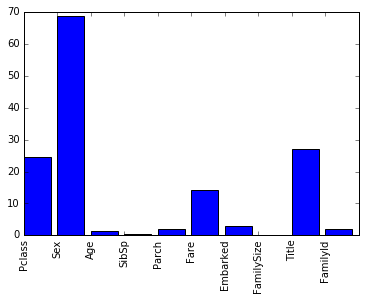

In [120]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [122]:
# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.811447811448


## Ensembling

In [124]:
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3),
     ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

In [125]:
# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

In [126]:
# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


C:\Users\Didier\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
